## Objectives:

 * Learn how to access and load text-based datasets
     * (find and download data from USGS and NCEI)
     * read CSV data using:
         * pandas
         * custom methods
 * manipulate strings using Python's built-in features (needed for parsing CSV files)
 * work with date-related data
 * generate basic plots
     
     
## Builds on skills from previous week:
Students should be able to:

 * develop an algorithm in terms of pseudo-code before writing code
 * write syntactically-valid Python code using:
     * loops
     * if-statements
     * lists (and maybe numpy arrays)
     * ubiquitous comments
     * functions
     * import statments
 * apply the scientific method for debugging
 * write basic functions
 * write code within Jupyter Notebooks and the Spyder development environments
 
## Lesson Details

Students will be asked to explore several hypotheses related to changes in the water level of South Lake Tahoe.  Hypothesis 1 is that *current low lake levels are related to unusually low winter precipitation*; and hypothesis 2 is that *unusually low lake levels are related to excessive dry-season evaporation due to global warming*.  Tests of these hypotheses will involve generating plots of lake level versus local/regional precipitation, and lake level versus local/regional temperature.

This will require, (1) finding the required data on the internet, (2) examining the downloaded data (using a text editor), (3) learning how to load the data, and (4) learning how to plot the data.

Instruction will be given at the beginning of the first class that:

 * introduces the idea of group projects,
 * explains the Tahoe hypotheses and their rationale, 
 * asks advanced students (those involved in research) to start thinking about potential projects (leaving the Tahoe project as a potential one),
     * asks all students to start forming groups with an advanced student as the lead,
     * informs students that projects will start in Week 3,
 * gives an introduction to reading text data (using the Week 1 precipitation dataset as an example),
 * gives some examples of manually parsing text data, and
 * introduces date manipulation.
 
 
## Instructor Key

The following code shows how Travis went about writing the code to accomplish the lesson's task.

I downloaded Lake Tahoe daily gage data from the USGS website (searched "lake tahoe depth data" and the 2nd entry was the USGS site), which provides at least monthly gage height (height above the lake surface elevation) data going back to April 30 1900. According to the website the gage datum (elevation) is 6220 ft, and the gage values are anomalies relative to this.


In [1]:
""" import necessary modules """
# this is specific to Jupyter; it causes plots to be drawn inline here
%matplotlib inline

import datetime as dt # load a module for dealing with dates
import pylab as PP # import a plotting library
import matplotlib as mpl # import another part of the plotting library (allows plot customization)
from numpy import * # load everything in numpy into the current namespace
import netCDF4 as nc # load the netCDF4 library, which gives access to the conveneient netCDF time utilities
from dateutil import parser # for parsing text-based dates
#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)

In [2]:
""" load and print the header of the Tahoe file """

tahoe_data_file = "../data/tahoe_gage_height_1990_to_2017.txt"

with open(tahoe_data_file,'r') as fin:
    file_lines = fin.readlines()
    
# print the first 35 lines
for i in range(35):
    print(file_lines[i].rstrip())

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2017-04-13 18:53:04 EDT       (caww02)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 10337000 LAKE TAHOE A TAHOE CITY CA
# ---------------------------------------------------------------

In [3]:
""" write a function to parse a line of the file """

def parse_file_line(line):
    """ Given a line from the USGS Tahoe gage datum file, parse the date gage datum.
    
        :param line: a line from the Tahoe gade datum file
        
        :rtype: (datetime,gageheight)
    
    There are two types of gageheight data used; this function returns whichever is available.
    """
    
    # The file is tab-separated and the header of the file states that the columns are ordered as follows:
    #
    #    agency_cd	site_no	datetime	02_00065_00011	02_00065_00011_cd	02_00065_32400	02_00065_32400_cd 5s	15s	20d	14n	10s	14n	10s
    #
    # The '02_00065_00011' and '02_00065_32400' fields are the gage data, and the fields ending in _cd are the quality
    # control flags.  The date is in the 'datetime' field.
    # 
    # So we want to return column 2 and column 3 or 5.
    
    if line[0] != "#":
        # parse the line into columns
        columns = line.split()

        # get either column 3 or 5
        try:
            gage_datum = float(columns[3])
        except:
            try:
                gage_datum = float(columns[5])
            except:
                gage_datum = None

        # parse the date only if there was valid data here
        if gage_datum is not None:
            # extract the year, month, and day from column 2
            year,month,day = columns[2].split('-')
            # convert it to a datetime object
            dtobj = dt.datetime(int(year),int(month),int(day))
        else:
            # otherwise set the date to None
            dtobj = None
    else:
        dtobj = None
        gage_datum = None
    
    return (dtobj,gage_datum)
    

In [4]:
""" test the function """

dates = []
gage_data = []

# Loop through a number of lines and see what we get
for i in range(32,200):
    dtobj, gage_datum = parse_file_line(file_lines[i])
    
    if dtobj is not None:
        dates.append(dtobj)
        gage_data.append(gage_datum)
        print(dtobj, gage_datum)



1900-04-30 00:00:00 6.37
1900-05-31 00:00:00 6.83
1900-06-30 00:00:00 7.0
1900-07-31 00:00:00 6.71
1900-08-31 00:00:00 6.2
1900-09-30 00:00:00 5.93


In [5]:
""" parse the entire file """
use_list_comprehension = False

if use_list_comprehension:
    # loop over all lines and parse the data (uses a list comprehension)
    gage_dates_and_data = \
        [ parse_file_line(file_lines[i]) for i in range(32,len(file_lines)) if parse_file_line(file_lines[i])[0] is not None ]
else:
    # Note that the above code uses a list comprehension to do the looping, which is often faster than a native do-loop
    # this is equivalent to the following code
    gage_dates_and_data = []
    for i in range(32,len(file_lines)):
        if parse_file_line(file_lines[i])[0] is not None:
            gage_dates_and_data.append(parse_file_line(file_lines[i]))

In [6]:
""" Extract the data in a plottable format """
# Note: the two methods below are equivalent

if use_list_comprehension:
    # use a list comprehension to convert the dates to numbers ( the number of days since the date printed below)
    # and then convert that to approximate years
    gage_dates = array([ dtobj for dtobj,_ in gage_dates_and_data ])
    # extract the gage height data
    gage_data = array([ gage_datum for _,gage_datum in gage_dates_and_data])
else:
    # loop over all the parsed data
    gage_dates = []
    gage_data = []
    for dtobj,gage_datum in gage_dates_and_data:
        # get the current date 
        gage_dates.append(dtobj)
        
        # extract the gage height data
        gage_data.append(gage_datum)
        
    # convert the lists to numpy arrays
    gage_dates = array(gage_dates)
    gage_data = array(gage_data)


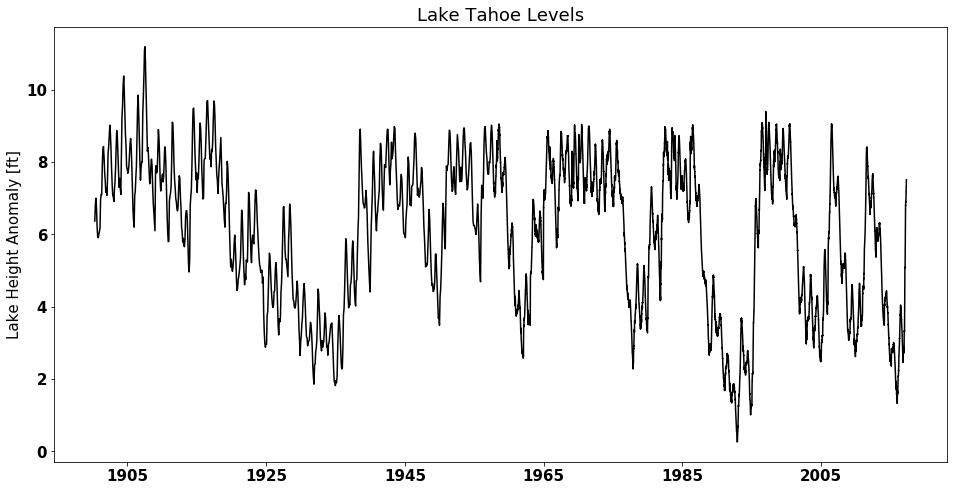

In [7]:
""" Plot the data """

# simultaneously create a figure (fig) and a plotting space (ax; this is termed axes in matplotlib lingo)
fig,ax = PP.subplots(figsize=(16,8))

# plot the gage heights versus years.  the 'k-' plots the data as a black (k) line (-)
ax.plot(gage_dates,gage_data,'k-')

# set axis labels
ax.set_ylabel('Lake Height Anomaly [ft]')

# generate a title
ax.set_title('Lake Tahoe Levels')

# draw the plot
PP.show()

